In [41]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



# ** WELL HAVE TO CHANGE THIS FOR THE CLUSTER
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext


TOYDATAFILE = './dac/trainpt1percentsample.txt'
FIELDS = ['Label'] + ['I'+str(i) for i in range(1,14)] + ['C'+str(i) for i in range(1,27)]
toyRDD = sc.textFile(TOYDATAFILE)

In [2]:
def ConvertNumber(idx, num):
    """
    convert hashes to ints
    """
    if num != '':
        if idx > 13:
            return int(num, 16)
        else:
            return int(num)
    else:
        return np.nan

def parse(line):
    """
    Map tab separated record to tuple of (39 features, label)
    """
    parsed = np.array([ConvertNumber(idx, num) for idx,num in enumerate(line.split('\t'))])
    features, label = parsed[1:], parsed[0]
    return (features, label)

def logloss(dataRDD, W):
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = (augmentedData.
            map(lambda x: (np.clip(1 / (1 + np.exp(-1*W @ x[0])), 1e-15, 1.0 - 1e-15), x[1])).
            map(lambda x: -1*np.log(x[0]) if x[1]==1.0 else -1*np.log(1-x[0])).mean())
    return loss

# Question Formulation

## Why Predict Click Through Rate (CTR)?
Display advertising is a multi-billion dollar industry. When a given company is deciding whether or not to buy ad space, they want to know how likely people are to click on those ads (prediction problem) and the advertiser like Criteo wants to have these predicts to back up their prices when selling ad space. Companies are also interested in what things they can change in order to get a higher click through rate. e.g., Should they use more personalization? Should they use brighter colors. A machine learning approach can help both better predictions and causal understanding.

## The Data

The data are a downsampled week's worth of ad-displays from CriteoLabs noting whether or not they were actually clicked. The downsampling makes it so we have a more balanced dataset with fewer non-click impressions.

The dataset is large
  - Training: 11GB
  - Test: 1.5GB
  
There are 40 total tab separated fields
  - The label (1 if clicked, 0 if not).
  - 13 Integer fields
  - 26 Categorical fields (hashed)

In [6]:
# Example rows:
!head -n 1 ./dac/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


Though we are not told exactly what these fields correspond to, they belong to the following categories:
  - Publisher features, such as the domain of the url where the ad was displayed;
  - Advertiser features (advertiser id, type of products,…)
  - User features, for instance browser type;
  - Interaction of the user with the advertiser, such as the number of the times the user visited the advertiser website.

If we had a model that told us which features were important, it would still be helpful to Criteo because they would be able to tell which of the above features they should focus on moving forward. For example, if browser type of Internet Explorer showed a much lower CTR than others, Criteo might explore that type and see there is a bug where ads are not displayed well.

## Question (key goal)

Our question is two fold
1. What is our best guess of the CTR for a given set of features?
2. Which features are most important in determining the CTR?

We will use logloss, recall, and precision on a validation set as our standard for 1. and use logistic regression in order to have coefficients that will help us answer 2. 

Logloss is good metric because it penalizes classifiers that are very confident in incorrect predictions. Thus, when we are analyzing our results that have optimized logloss, we are more confident that we have a well-calibrated model (that as our predictions increase, so do the true probabilities). Recall will give us sense of how many of the clicks we actually capture, while precision will tell us how conservative our model is with predicting clicks. 

Improving prediction accuracy on a validation set from a baseline guess-the-mean strategy by a small amount, even ~0.5%, has significant consequences given the huge dollar base of this billion-dollar industry. 

# Algorithm Explanation

An appropriate model to answer both of our key questions above is Logistic Regression. It is an intretatble binary classifer that often works well when we have a long feature vector with many one-hot encoded variables (e.g., it is often the go to for NLP basedline models with bag-of-words one hot encoding https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e). 

## 1.  What is our best guess of the CTR for a given set of features?

Logistic regression works similarly to linear regression, but instead of fitting a hyper-plane to a set of training points in the feature space, it fits a sigmoid function to a set of binary-class training examples. The value of the sigmoid function at a given point in the feature space is the predicted probability that a person has clicked on the ad in our analysis.

This is an improvement over linear regression for classification because its predictions are restricted to be between 0 and 1 like probabilities should be.

More formally, logistic regression models the log-odds of a click as a linear function of the features:

$$
\ln\frac{p}{1-p} = \beta X + e
$$

Where $p$ is a vector of the probabilities that an ad is clicked, $\beta$ is a vector of coefficients to be estimated that define the sigmoid function, $X$ is a matrix of features in our model, and $e$ is an error term.

In [5]:
Image(url= "https://www.saedsayad.com/images/LogReg_1.png")

Logisitic regression does assume that the data are linearly separable into the binary classes in the feature space, but this simple assumption is what gives us the great interpretability through coefficients. Even though this assumption doesn't perfectly hold (which means we will have some bias in our estimates), the simplicity of a linear model reduces the variance of our predicts as well. Also, given that we have a fairly large number of features, this linearity assumption may not cause too much bias in practice. Another assumption in logisitc regression is that all the points are indpendently generated. This is likely false again because some data points might come from the same customer coming back to the site and seeing the same add a second time. Even though all the feature (besides time) might be the same here, there is likely correlation between whether or not that customer will click. However, this assumption likely just increase the standard errors of our coefficients instead of biasing them.

### Maximum Likelihood Estimator (MLE)

To estimate $\beta$, we use the MLE. Logisitic regression assumes each label is independently drawn from a Bernoulli distribution with a probability that is a function of the features: $y_i \sim Bernoulli(p(x_i))$. This translates to a likelihood across all $N$ datapoints of:

$$
L(\beta) = \Pi_{i=1}^{N} p(x_i)^{y_i}(1-p(x_i))^{1-y_i}
$$

Sums behave better than products, so we can use the monotonic log transform to make this likelihood better behaved. The log-likelihood is:

$$
l(\beta) = \sum_{i=1}^{N} y_i\ln p(x_i) + (1-y_i)\ln (1-p(x_i)) \\
= \sum_{i=1}^{N} y_i\ln \frac{p(x_i)}{1-p(x_i)} + \ln (1-p(x_i))
$$

Then we can substitute $\beta x_i$ in for the log odds and $\frac{1}{1+e^{-\beta x_i}}$ for $p$:

$$
= \sum_{i=1}^{N} y_i \beta x_i + \ln (1-\frac{1}{1+e^{-\beta x_i}}) \\
= \sum_{i=1}^{N} y_i \beta x_i + \ln (\frac{e^{-\beta x_i}}{1+e^{-\beta x_i}}) \\
= \sum_{i=1}^{N} y_i \beta x_i - \beta x_i - \ln( 1+e^{-\beta x_i}) 
$$

This function has no closed-form maximum, so we use gradient ascent to climb the surface of $l$ in the space of $\beta$. Differentiating the above with respect to $\beta$ gives us the gradient.

$$
\nabla_{\beta} l = \sum_{i=1}^{N} x_i y_i - x_i + \frac{x_i e^{-\beta x_i}}{1+e^{-\beta x_i}} \\
= x_i (y_i - \frac{1}{1+e^{-\beta x_i}})
$$

Then, our algorithm is as follows:

1. Specify a baseline $\hat{\beta}$ as an initialization
2. Calculate $\frac{\nabla_{\beta} l}{N}$. Note here that each $i$'s contribution to the sum is independent, so we can distribute the work across a cluster to calculate the gradient in each iteration. We also change to the average contribution per $i$ by dividing by $N$ instead of using the sum. This way, the magnitude is not proportional to the number of data points and we can keep the same learning rate for any number of training points.
3. Update $\hat{\beta} := \hat{\beta} + \alpha \frac{\nabla_{\beta} l}{N}$. Here $\alpha$ is the learning rate.
4. Repeat 2-3 for the specified number of iterations. (this could be improved to stop when the calculated gradient is small enough, but to keep things simple we have a fixed number of iterations).


Luckily the log likelihood $l$ is a concave function, so we know that if we set our learning rate small enough, we will reach a global maximum. (see https://homes.cs.washington.edu/~marcotcr/blog/concavity/)

This will be accomplished by the following function:

In [64]:
def GDUpdate(dataRDD, W, learningRate = 0.05, regType = None, regParam = 0):
    """
    Perform one gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    
    
    # use negative log likelihood to keep it descent
    grad = augmentedData.map(lambda x: -x[0]*(x[1] - (1/(1+np.exp(-1*np.dot(W, x[0])))))).mean()
    if regType=='l1':
        grad[1:] += 2 * regParam * W[1:]
    elif regType=='l2':
        grad[1:] += regParam * np.sign(W[1:])

    new_model = W - learningRate * grad 
   
    return new_model


Just like linear regression, logistic regression can overfit to the training data if too many features are used. To adjust for this, we can use L1 or L2 regularization to select coefficients / keep coefficients small. To do so we can add a penalty to the log-likelihood to get a new function $J$ to climb:

$$
J = l(\beta) - \lambda penalty(\beta)
$$

L2 Regularization would be 

$$
J = l(\beta) - \lambda \sum_{j=1}^{m} \beta_j^2 
$$

with new corresponding gradient of:

$$
\nabla_{\beta} J = x_i (y_i - \frac{1}{1+e^{-\beta x_i}}) - 2 \lambda \beta_j
$$

L1 would be 

$$
J = l(\beta) - \lambda \sum_{j=1}^{m} |\beta_j| 
$$

with new corresponding gradient of:

$$
\nabla_{\beta} J = x_i (y_i - \frac{1}{1+e^{-\beta x_i}}) - \lambda sign(\beta_j)
$$

Our algorithm could use the adjusted $\nabla_{\beta} J$ instead of $\nabla_{\beta} l$ in steps 2 and 3 to avoid over-fitting or to choose which variables are important.

Here $\lambda$, the regularization parameter, controlls the level of regularization. The higher the value of $\lambda$, the more bias we will add, but the less variance we will have.

### Predictions
Once we have $\hat{\beta}$, to make predicted probabilities we solve for $p$ in the log odds formula above:
$$
\hat{p} = \frac{1}{1+e^{-\hat{\beta} x_i}}
$$

Then, our log loss metric is:
$$
logloss = \frac{1}{N} \sum_{i=1}^{N} -y_i \log \hat{p_i} - (1-y_i) \log(1-\hat{p_i})
$$

Again each $i$'s contribution to the logloss is independent so the calculation on a validation set can be distributed.

In [40]:
def logloss(dataRDD, W):
    """
    Calculates the mean log loss from an RDD of (np.array features, labels)
    and a weights array W
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = (augmentedData.
            map(lambda x: (np.clip(1 / (1 + np.exp(-1*W @ x[0])), 1e-15, 1.0 - 1e-15), x[1])).
            map(lambda x: -1*np.log(x[0]) if x[1]==1.0 else -1*np.log(1-x[0])).mean())
    return loss

## 2. Which features are most important in determining the CTR?

The estimated coefficients $\hat{\beta}$ also enable us to interpret the impact of a given feature. For the numeric features, the interpretation is that if the value of featuer $x_j$ increased by one (or if the standard deviation increased by one if normalized to unit variance), the log odds would be predicted to increase by $\hat{\beta_j}$. For features that are one-hot encoded (like our categorical features), $\beta_j$ represents the increase in the log odds from going from the base category (the one category left out of the regression) to the category represented by a one in $x_j$. 

If we standardize all features, the ones with the highest magnitude coefficients could be considered to have the most impact of the probability of a click. 


## Toy Example without regularization

To illustrate logistic regression, we use a 0.1% percent random sample from the training data created with `!shuf -n 45841 train.txt > trainpt1percentsample.txt`. We'll train a model:

$$
logoddsclick = \beta_0 + \beta_1 I_1 + \beta_2 C_2
$$

Here $I$ is a numeric field from the data and $C$ is a categorical transformed into a binary flag (like a one hot encoding for a 2-valued categorical).

In [31]:
# first get the data ready
toyRDD_intermediate = (
    toyRDD.map(parse) # parse the raw data
    # pull one numeric and one categorical feature transformed into a binary indicator (like a one hot encoding)
    .map(lambda x: (np.array([x[0][1], 0 if x[0][26] < 1 else 1]), x[1]))
) 
# pull mean and standard deviation to standardize numeric feature later 
mean_numeric =  toyRDD_intermediate.map(lambda x: x[0][0]).mean()
std_numeric =  toyRDD_intermediate.map(lambda x: x[0][0]).variance()**0.5   
toytrainRDD, toyheldOutRDD =(
    # standardize the numeric feature to stablize the algorithm
    toyRDD_intermediate.map(lambda x: (np.array([(x[0][0] - mean_numeric)/std_numeric,x[0][1]]), x[1]))
    # separate into train and validation sets
    .randomSplit([0.8,0.2], seed = 1)
)

In [52]:
# train the logistic regression
W = np.array([-1,-1.5,.1])
print(f"Initial Model: {[round(w,3) for w in W]}")
print(f"Initial Train Loss = {logloss(toytrainRDD,W)}")
print(f"Initial Held-Out Loss = {logloss(toyheldOutRDD,W)}")
n_iterations = 20
for i in range(n_iterations):
    print("-----------------------------------------------------")
    print("iteration # {}".format(i))
    W = GDUpdate(toytrainRDD, W, learningRate = 1)
    print(f"New Model: {[round(w,3) for w in W]}")
    print(f"Train Loss = {logloss(toytrainRDD,W)}")
    print(f"Held-Out Loss = {logloss(toyheldOutRDD,W)}")

Initial Model: [-1.0, -1.5, 0.1]
Initial Train Loss = 0.673093259449749
Initial Held-Out Loss = 0.6774833986160038
-----------------------------------------------------
iteration # 0
New Model: [-1.082, -1.411, 0.018]
Train Loss = 0.6554675536953056
Held-Out Loss = 0.6595849855422558
-----------------------------------------------------
iteration # 1
New Model: [-1.126, -1.33, -0.026]
Train Loss = 0.6463127417271598
Held-Out Loss = 0.6501576256516545
-----------------------------------------------------
iteration # 2
New Model: [-1.149, -1.254, -0.049]
Train Loss = 0.6398856840016004
Held-Out Loss = 0.6435087839347325
-----------------------------------------------------
iteration # 3
New Model: [-1.16, -1.181, -0.06]
Train Loss = 0.6344722234885993
Held-Out Loss = 0.6378745296155612
-----------------------------------------------------
iteration # 4
New Model: [-1.165, -1.109, -0.065]
Train Loss = 0.6294770195631495
Held-Out Loss = 0.6326607903242772
----------------------------------

The logloss gets lower as we climb the likelihood function.

Our fit model is
$$
logoddsclick= -1.101 + -0.189 I_1 + -0.001 C_2
$$

So each standard deviation increase in $I$ makes the log-odds of a click predicted .189 lower and going from the category variable havign a value below 1 to above 1 hardly changes the log odds with a small .001 predicted decrease. We can visualize the predicted probability of our model for each value of $C_2$ across values of I:

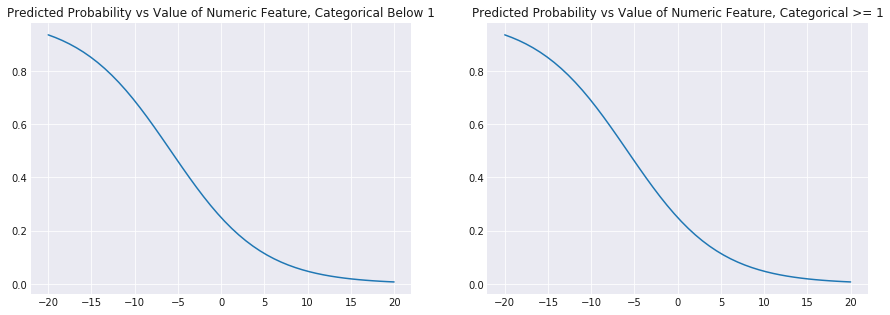

In [55]:
I = np.linspace(-20,20)
P_C0 = 1/(1+np.exp(-(W[0]+W[1]*I)))
P_C1 = 1/(1+np.exp(-(W[0]+W[1]*I+W[2])))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

ax1.plot(I,P_C0)
ax1.set_title('Predicted Probability vs Value of Numeric Feature, Categorical Below 1', color='0.1')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

ax2.plot(I,P_C0)
ax2.set_title('Predicted Probability vs Value of Numeric Feature, Categorical >= 1', color='0.1')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)

plt.show()

Both curves are bounded between 0 and 1 and decrease as $I_1$ increases. They are nearly identical curves because the coefficient on $C_2$ is small.

Though given our data above we don't seem to be overfitting because the training loss is close to the validation loss, we only have 2 features in this model. If we had many more regularization would make sense to keep coefficeint values small. For example, if we use L2 regularization instead we see the estimated coefficient values are all below 1 in magnitude:

# Application of Course Concepts

This assignment encompasses a number of the key concepts of W261. 

## bias variance tradeoff / model complexity / regularization  / model assumptions
Instead of using all parameters in our model, we balanced bias and variance by removing variables that were not important according to L1 regularization. This reduces the variance and increases the bias. Also, our general choice of a simple model (logistic regression) likely adds bias due to the linearly separable assumption, but reduces variance for the same reason.

## GD - convex optimization / Batch / Normalization
We have also implemented a scalable batch gradient descent approach. The approach is scalable because it distributes the task of calculating the gradient accross a cluster. Each data point's contribution to the gradient is independent so this calculation is embarrasingly parallel. We also know that if we set the learning rate small enough and have a large enough number of iterations, we will reach the coefficients that give the global maximum likelihood. This is because the log likelihood function we are climbing is concave such that there is only 1 global maximum and no local ones that we might accidentally end up in. Wihtout standardizing the variables, gradient descent becomes unstable. Thus, we used a distributed method to make all numeric variables have 0 mean and unit variance. 

Given that this dataset was a small subset of the data that would actually be used in practice, other methods would not be able to handle it like our method. For example, sequentially moving through the data on one node would take too long given that we would have to loop over it multiple times. Holding all the data in memory on a single node is also unreasonably expensive given that the real data likely has many billions of rows.

## Caching and Broadcasting

**(we should make sure we actually do use broadcasting and caching so this is true)**
To make our computations faster, we cache the training data set so it is availble in memory for each iteration. We also broadcast the value of the coefficients so that they are available on all nodes in doing the gradient calculation and update. Without caching, a lot more time would be spent processing the data. Without broadcasting explicitly, the master node would have to do more work. With broadcasting, the worker nodes have the information they need locally.

## One Hot Encoding / Feature Selection
Given the high-cardinality categorical features of this dataset, we have needed to do a lot of feature selection. Our EDA informed which variables might be important. From there, we also used L1 regularization to see which coefficients dropped. At the same time, the cardinality of our categorical features means that we could not one hot encode all values. However, because we do not know the difference between the different values, the hashing trick to reduce dimensionality works well. Then we can one hot encode the categorical with its reduced cardinality having a column for each of the new values except one base value. Then, the coefficients on these one-hot encoding fields are the changes in log likelihood that occur if we move from the base value of the categorical variable to the value encoded in that column.

## Spark vs Map Reduce

We chose to do our implementation in Spark instead of Map Reduce. Spark is much more efficient when it comes to multi-pass computations like our iterative gradient calculations. Spark allows us to do our data transformations without requiring us to write to disk after each step. This heavy IO in the map reduce framework would make our data preparation phase much longer. 

# Conclusion

In this project we have used data from Criteo Labs to train a logisitc regression that 1. predicts click through rates given available features and 2. gives us a high level understand of which features are more important in determining the predicted probability of a click. We conducted a thourough EDA indicating that many categorical variables had high cardinality and needed to be reduced to a smaller space before one hot encoding. Our algorithm's gradient descent implementation in Spark is scalable. We found a ** improvement over the baseline guess-the-mean strategy. Overall our methods illustrate a number of the key concepts covered in the course, which allow us to have a solution that scales to the true size of the data.